In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Import

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd
import unicodedata
import re
import numpy as np
import os
import io
import time
from string import digits

Load the dataset

In [52]:
#Read the data
data_path = "/content/gdrive/My Drive/NLP/tur.txt"
lines_raw= pd.read_table(data_path,names=['source', 'target', 'a'])
lines_raw.sample(5)

,source,target,a
634,I'm a nurse.,Hemşireyim.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
125381,Many sects have initiation rituals for new mem...,Birçok tarikatın yeni üyeler için başlangıç ​​...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
113257,Tom moved closer to see what was going on.,Tom neler olduğunu görebilmek için yanaştı.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
41339,The world has five oceans.,Dünyada beş tane okyanus vardır.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
53367,My brother is older than me.,Erkek kardeşim benden büyüktür.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...


Prepocess the dataset

In [0]:
def preprocess_sentence(sentence):
    #sentence = unicode_to_ascii(sentence.lower().strip())
    num_digits= str.maketrans('','', digits)
    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= re.sub("ç", "c", sentence)
    sentence= re.sub("ö", "o", sentence)
    sentence= re.sub("ı", "i", sentence)
    sentence= re.sub("ğ", "g", sentence)
    sentence= re.sub("ü", "u", sentence)
    sentence= re.sub("ş", "s", sentence)
    sentence= sentence.translate(num_digits)
    sentence= sentence.strip()
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    
    return sentence

In [54]:
sentence = u"Tom geçen pazartesi Boston'a geldi."
print(preprocess_sentence(sentence).encode('utf-8'))

b'start_ tom gecen pazartesi bostona geldi . _end'


In [0]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  x = lines[0].split('\t')[0:2]
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[0:2]]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [56]:
sample_size=60000
source, target = create_dataset(data_path, sample_size)
print(source[-1])
print(target[-1])

start_ security was extremely tight . _end
start_ guvenlik son derece sikiydi . _end


In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
source_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post' )

target_sentence_tokenizer= tf.keras.preprocessing.text.Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor,padding='post' )

max_target_length= max(len(t) for t in  target_tensor)
max_source_length= max(len(t) for t in  source_tensor)

In [59]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor= train_test_split(source_tensor, target_tensor,test_size=0.2)
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(source_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

48000 48000 12000 12000


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [61]:
print ("Input Language; index to word mapping")
convert(source_sentence_tokenizer, source_train_tensor[0])
print ("Target Language; index to word mapping")
convert( target_sentence_tokenizer, target_train_tensor[0])

Input Language; index to word mapping
1 ----> start_
5 ----> i
8625 ----> struggled
31 ----> for
9 ----> a
443 ----> few
1419 ----> months
3 ----> .
2 ----> _end
Target Language; index to word mapping
1 ----> start_
262 ----> birkac
730 ----> ay
542 ----> boyunca
11665 ----> ugrastim
3 ----> .
2 ----> _end


In [0]:
BUFFER_SIZE = len(source_train_tensor)
BATCH_SIZE = 512
steps_per_epoch = len(source_train_tensor)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_sentence_tokenizer.word_index)+1
vocab_tar_size = len(target_sentence_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [87]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([512, 12]), TensorShape([512, 14]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [89]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (512, 12, 1024)
Encoder Hidden state shape: (batch size, units) (512, 1024)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [91]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (512, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (512, 12, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [93]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (512, 27133)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [99]:
EPOCHS = 25

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    #if batch % BATCH_SIZE == 0:
    print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
      
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 loss 2.603343963623047
Epoch 1 Batch 1 loss 2.5937812328338623
Epoch 1 Batch 2 loss 2.5732998847961426
Epoch 1 Batch 3 loss 2.5598866939544678
Epoch 1 Batch 4 loss 2.592618465423584
Epoch 1 Batch 5 loss 2.497288465499878
Epoch 1 Batch 6 loss 2.5177695751190186
Epoch 1 Batch 7 loss 2.5041568279266357
Epoch 1 Batch 8 loss 2.5405240058898926
Epoch 1 Batch 9 loss 2.5173771381378174
Epoch 1 Batch 10 loss 2.515714168548584
Epoch 1 Batch 11 loss 2.4557788372039795
Epoch 1 Batch 12 loss 2.497453212738037
Epoch 1 Batch 13 loss 2.487307548522949
Epoch 1 Batch 14 loss 2.4712512493133545
Epoch 1 Batch 15 loss 2.495346784591675
Epoch 1 Batch 16 loss 2.5118398666381836
Epoch 1 Batch 17 loss 2.451035499572754
Epoch 1 Batch 18 loss 2.466735363006592
Epoch 1 Batch 19 loss 2.433310031890869
Epoch 1 Batch 20 loss 2.4613921642303467
Epoch 1 Batch 21 loss 2.4225175380706787
Epoch 1 Batch 22 loss 2.4479880332946777
Epoch 1 Batch 23 loss 2.460169553756714
Epoch 1 Batch 24 loss 2.4296643733978

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_target_length, max_source_length))

  sentence = preprocess_sentence(sentence)
  #print(sentence)
  #print(source_sentence_tokenizer.word_index)

  inputs = [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)

  for t in range(max_target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += target_sentence_tokenizer.index_word[predicted_id] + ' '

    if target_sentence_tokenizer.index_word[predicted_id] == '_end':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)
  
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [104]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: start_ i am going to school . _end
Predicted translation: ben okula gidiyorum . _end 


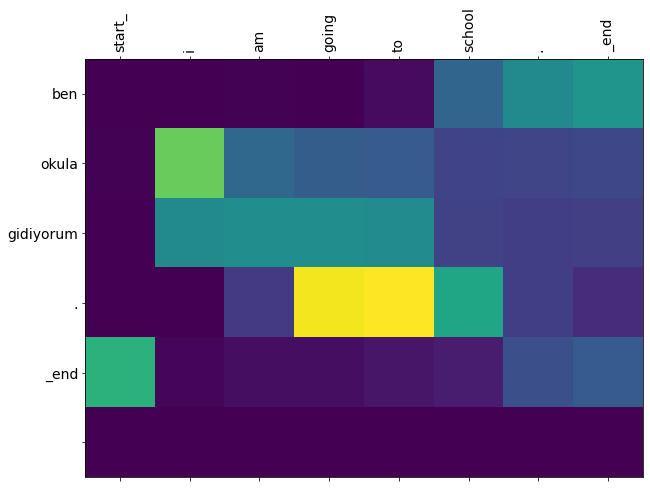

In [106]:
translate(u'I am going to school.')

Input: start_ you need to go . _end
Predicted translation: gitmeniz gerekiyor . _end 


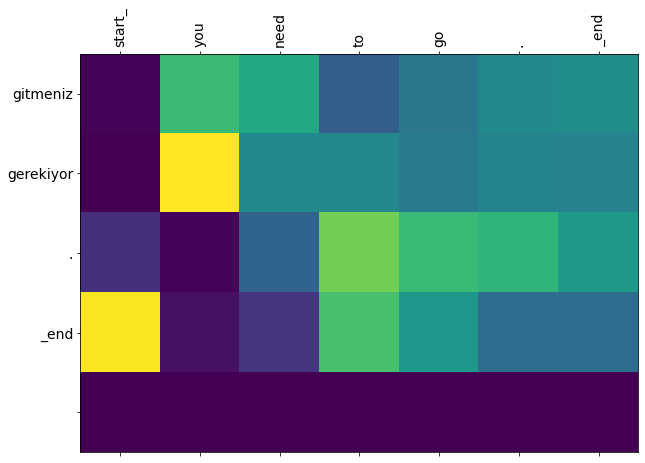

In [109]:
translate(u'You need to go.')

Input: start_ i am a teacher . _end
Predicted translation: ben bir i̇ngilizce ogretmeniyim . _end 


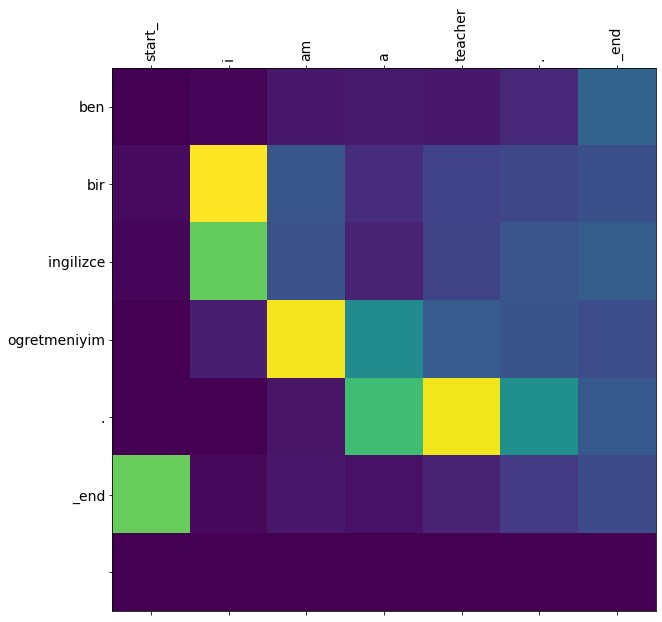

In [113]:
translate(u'I am a teacher.')